# 1. Script set-up

In [1022]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Import data

In [1023]:
#import data
df = pd.read_csv('dft_traffic_counts_aadf_by_direction.csv')

print(df.shape)
df.head(5)

(807055, 35)


,count_point_id,year,region_id,region_name,region_ons_code,local_authority_id,local_authority_name,local_authority_code,road_name,road_category,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,51,2000,1,South West,E12000009,1,Isles of Scilly,E06000053,A3111,PA,...,25,451,30,0,0,0,0,0,30,1430
1,52,2000,1,South West,E12000009,1,Isles of Scilly,E06000053,A3112,PA,...,16,250,11,0,0,0,0,0,11,1140
2,53,2000,1,South West,E12000009,1,Isles of Scilly,E06000053,A3111,PA,...,16,264,15,0,0,0,0,0,15,884
3,54,2000,1,South West,E12000009,1,Isles of Scilly,E06000053,A3110,PA,...,15,214,14,0,0,0,0,0,14,774
4,55,2000,1,South West,E12000009,1,Isles of Scilly,E06000053,A3110,PA,...,2,41,14,0,0,0,0,0,14,272


# 3. Cleaning data

## 3.1. General cleaning

In [1024]:
# Drop columns that won't be used
df.drop(['count_point_id','region_id','region_ons_code','local_authority_id','local_authority_code','easting','northing','estimation_method_detailed','link_length_miles','hgvs_2_rigid_axle','hgvs_3_rigid_axle','hgvs_4_or_more_rigid_axle','hgvs_3_or_4_articulated_axle','hgvs_5_articulated_axle','hgvs_6_articulated_axle','region_name','local_authority_name','road_category','start_junction_road_name','end_junction_road_name','estimation_method'],axis=1, inplace=True)

As there are far more rows of data than could be used, we'll have to be very selective.

In [1025]:
# Only consider most recent year
df=df.loc[df['year']==2018].drop('year',axis=1)

# Drop minor roads
df=df.loc[df['road_type']=='Major']

print(df.shape)
df.head(5)

(34285, 13)


,road_name,road_type,latitude,longitude,link_length_km,direction_of_travel,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles
763791,A3111,Major,49.915023,-6.317073,0.3,E,116,51,308,12,251,26,648
763792,A3111,Major,49.915023,-6.317073,0.3,W,105,42,237,13,200,18,510
763793,A3112,Major,49.912343,-6.305686,2.0,E,43,35,303,0,130,5,474
763794,A3112,Major,49.912343,-6.305686,2.0,W,38,42,332,8,133,7,522
763795,A3111,Major,49.917141,-6.306114,1.2,E,83,44,395,7,232,11,689


## 3.2. Removing rows which do not lie around a road tunnel

This requires using the co-ordinates from the 'tunnels_list.csv' previously produced

In [1026]:
#import data
t_df = pd.read_csv('tunnels_list.csv')

In [1027]:
t_df.head(5)

,TunnelName,WikiLink,TunnelType,Length[m],OpeningDate,Latitude,Longitude
0,Ampthill Tunnel,/wiki/Ampthill_Tunnel,Railway,654.0,1859,52.033611,-0.513333
1,Linslade Tunnel,/wiki/Linslade_Tunnel,Railway,249.0,"1837, 1859, 1876",51.925278,-0.676389
2,Old Warden Tunnel,/wiki/Old_Warden_Tunnel,Railway,807.0,1853,52.088333,-0.375833
3,Wymington Tunnel,No link,Railway,1690.0,1859,NaN,NaN
4,Clifton Down Tunnel,/wiki/Clifton_Down_Tunnel,Railway,1601.0,1874,51.469444,-2.618889


In [1028]:
print('Original number of rows: ' + str(t_df.shape[0]))

Original number of rows: 512


Reducing dataframe to only consider road tunnels with coordinates

In [1029]:
#Drop columns that don't help
t_df.drop(['WikiLink','Length[m]','OpeningDate'],axis=1,inplace=True)

#Drop rows without co-ordinates
t_df.dropna(inplace=True)

In [1030]:
# Get a list of the different types of road tunnel
t_df['TunnelType'].loc[t_df['TunnelType'].str.lower().str.contains("road")].unique()

array(['Road', 'Road (A3066)', 'tramroad', 'Tramroad'], dtype=object)

In [1031]:
# Only keep road tunnels
t_df=t_df.loc[t_df['TunnelType'].str.contains("Road")]
print('Reduced number of rows: ' + str(t_df.shape[0]))
t_df.head(5)

Reduced number of rows: 26


,TunnelName,TunnelType,Latitude,Longitude
13,Saltash Tunnel,Road,50.411667,-4.215000
85,Beaminster Tunnel,Road (A3066),50.826111,-2.756944
93,Cuilfail Tunnel,Road,50.875556,0.017778
109,Dartford Tunnel,Road,51.464722,0.258611
150,Weston Hills Tunnel,Road,51.977778,-0.176667


In [1032]:
# These will be used as look-up columns
lat_list = t_df.Latitude.to_list()
lon_list = t_df.Longitude.to_list()

In [1033]:
def near_road_tunnel(dataframe):
    
    #Degree limit in which a road is considered close to a tunnel
    distance_limit = 0.05

    #Method: 
    #1. Goes through the latitude list and records tunnel indexes which the latitude is similar to.
    #2. Goes through the longitude list and records tunnel indexes which the longitude is similar to.
    #3. Compares the two lists and outputs true if any number is in both lists

    lat_temp = []
    for tunnel_latitude in lat_list:
        if abs(dataframe['latitude'] - tunnel_latitude) < distance_limit:
            lat_temp.append(lat_list.index(tunnel_latitude))

    lon_temp = []
    for tunnel_longitude in lon_list:
        if abs(dataframe['longitude'] - tunnel_longitude) < distance_limit:
            lon_temp.append(lon_list.index(tunnel_longitude))            

    #Default value
    output = False
    
    #If a number is in both lists then true
    for i in lat_temp:
        if i in lon_temp:
            output = True    
    
    return output

In [1034]:
# Apply function to dataframe to create new column
df['useful']=df.apply(near_road_tunnel,axis=1)
df.head(5)

,road_name,road_type,latitude,longitude,link_length_km,direction_of_travel,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles,useful
763791,A3111,Major,49.915023,-6.317073,0.3,E,116,51,308,12,251,26,648,False
763792,A3111,Major,49.915023,-6.317073,0.3,W,105,42,237,13,200,18,510,False
763793,A3112,Major,49.912343,-6.305686,2.0,E,43,35,303,0,130,5,474,False
763794,A3112,Major,49.912343,-6.305686,2.0,W,38,42,332,8,133,7,522,False
763795,A3111,Major,49.917141,-6.306114,1.2,E,83,44,395,7,232,11,689,False


In [1035]:
print("Using: " + str(df.loc[df['useful']==True].shape[0]))
print("Ignoring: " + str(df.loc[df['useful']==False].shape[0]))

Using: 2349
Ignoring: 31936


In [1036]:
# Remove all rows that are not being used
df=df.loc[df['useful']==True]
print(df.shape)
df.head(5)

(2349, 14)


,road_name,road_type,latitude,longitude,link_length_km,direction_of_travel,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles,useful
763808,M4,Major,51.579980,-3.034481,2.2,N,0,174,47694,221,8577,4624,61291,True
763809,M4,Major,51.579980,-3.034481,2.2,S,0,129,44593,238,7979,5109,58048,True
763852,A470,Major,53.240962,-3.799615,6.8,N,1,42,2964,30,819,144,3998,True
763853,A470,Major,53.240962,-3.799615,6.8,S,4,36,2910,34,800,134,3913,True
763894,A4051,Major,51.604672,-3.008531,2.5,N,27,96,15375,228,2418,422,18539,True


## 3.3 Removing duplicate rows

Converting bi-directional duplicate rows into an averaged value

In [1037]:
#Exploring values
df['direction_of_travel'].unique()

array(['N', 'S', 'E', 'W', 'C'], dtype=object)

In [1038]:
# Adding a unique identifier column to group on
df['to_group_on'] = df['road_name'] + '_' + df['latitude'].astype(str) + '_' + df['longitude'].astype(str)
df.head(5)

,road_name,road_type,latitude,longitude,link_length_km,direction_of_travel,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles,useful,to_group_on
763808,M4,Major,51.579980,-3.034481,2.2,N,0,174,47694,221,8577,4624,61291,True,M4_51.57997959_-3.03448149
763809,M4,Major,51.579980,-3.034481,2.2,S,0,129,44593,238,7979,5109,58048,True,M4_51.57997959_-3.03448149
763852,A470,Major,53.240962,-3.799615,6.8,N,1,42,2964,30,819,144,3998,True,A470_53.24096228_-3.79961517
763853,A470,Major,53.240962,-3.799615,6.8,S,4,36,2910,34,800,134,3913,True,A470_53.24096228_-3.79961517
763894,A4051,Major,51.604672,-3.008531,2.5,N,27,96,15375,228,2418,422,18539,True,A4051_51.60467176_-3.00853128


In [1039]:
#Creating a look-up table to re-add road_name after grouping
df_lookup = df[['road_name','to_group_on']].copy()
df_lookup.drop_duplicates(subset ='to_group_on', keep = 'first', inplace = True)
df_lookup.head(5)

,road_name,to_group_on
763808,M4,M4_51.57997959_-3.03448149
763852,A470,A470_53.24096228_-3.79961517
763894,A4051,A4051_51.60467176_-3.00853128
764003,A48,A48_51.56527367_-3.01128036
764009,A547,A547_53.282606900000005_-3.83013628


In [1040]:
# Taking the mean values for traffic data at the points (therefore ignoring direction)
df = df.groupby('to_group_on').mean()
df.head(5)

,latitude,longitude,link_length_km,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles,useful
to_group_on,,,,,,,,,,,
A1(M)_51.9459099_-0.21186492,51.945910,-0.211865,4.2,0.0,211.5,34685.0,78.0,6508.5,2413.0,43896.5,True
A1(M)_51.98164778_-0.19682669,51.981648,-0.196827,5.3,0.0,117.5,19698.0,22.0,3740.0,1893.5,25471.0,True
A1(M)_52.01086521_-0.2035063,52.010865,-0.203506,0.4,0.0,81.0,13547.0,15.0,2565.5,1301.0,17509.5,True
A1(M)_52.01415064_-0.20550227,52.014151,-0.205502,0.4,0.0,81.0,13547.0,15.0,2565.5,1301.0,17509.5,True
A100_51.49605897_-0.08257754,51.496059,-0.082578,0.4,674.0,815.0,7937.5,410.5,3070.5,308.5,12542.0,True


In [1041]:
print(df.shape)
print(df_lookup.shape)

(1291, 11)
(1291, 2)


In [1042]:
# Re-adding the road-name through an inner join
df = pd.merge(df, df_lookup, how='inner', left_on='to_group_on', right_on='to_group_on')

#Remove the columns that are no longer required
df.drop(['to_group_on','useful'],axis=1,inplace=True)

In [1043]:
# Check final output
print(df.shape)
df.head(5)

(1291, 11)


,latitude,longitude,link_length_km,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles,road_name
0,51.945910,-0.211865,4.2,0.0,211.5,34685.0,78.0,6508.5,2413.0,43896.5,A1(M)
1,51.981648,-0.196827,5.3,0.0,117.5,19698.0,22.0,3740.0,1893.5,25471.0,A1(M)
2,52.010865,-0.203506,0.4,0.0,81.0,13547.0,15.0,2565.5,1301.0,17509.5,A1(M)
3,52.014151,-0.205502,0.4,0.0,81.0,13547.0,15.0,2565.5,1301.0,17509.5,A1(M)
4,51.496059,-0.082578,0.4,674.0,815.0,7937.5,410.5,3070.5,308.5,12542.0,A100


# 4. Quick analysis

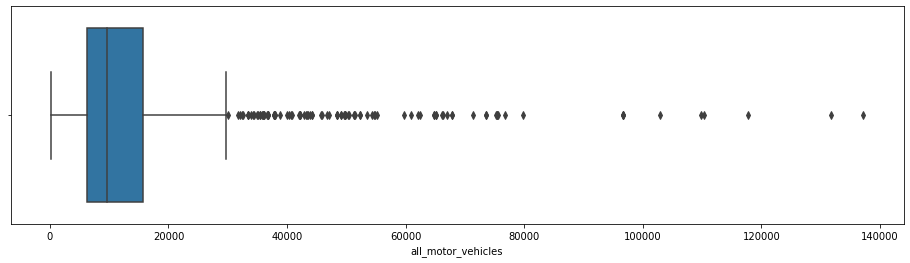

In [1066]:
plt.figure(figsize=[16,4])
sns.boxplot(y='all_motor_vehicles',data=df,orient = 'h')

In [1068]:
# Roughly use this to colour code the traffic on the map
df.all_motor_vehicles.quantile([0.25,0.5,0.75])

0.25     6198.25
0.50     9698.50
0.75    15712.75
Name: all_motor_vehicles, dtype: float64

# 5. Export output

In [1044]:
#Export cleaned traffic data
df.to_csv('traffic_data.csv', index=False)

In [1045]:
print('Complete')

Complete
